In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
data = pd.read_csv("breast-cancer.csv")
data.head(10)

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,M
1,20.57,17.77,132.90,1326.0,0.08474,M
2,19.69,21.25,130.00,1203.0,0.10960,M
3,11.42,20.38,77.58,386.1,0.14250,M
4,20.29,14.34,135.10,1297.0,0.10030,M
5,12.45,15.70,82.57,477.1,0.12780,M
6,18.25,19.98,119.60,1040.0,0.09463,M
7,13.71,20.83,90.20,577.9,0.11890,M
8,13.00,21.82,87.50,519.8,0.12730,M
9,12.46,24.04,83.97,475.9,0.11860,M


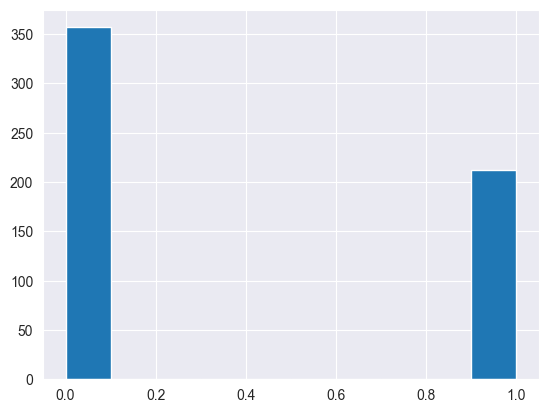

In [16]:
data["diagnosis"].hist()
figsize=(10, 6)

<Axes: >

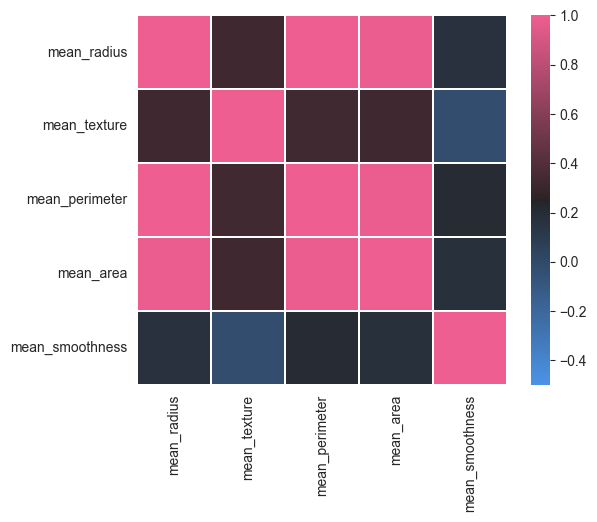

In [4]:
corr = data.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

In [5]:
data = data[["mean_radius", "mean_texture", "mean_smoothness", "diagnosis"]]
data.head(10)

,mean_radius,mean_texture,mean_smoothness,diagnosis
0,17.99,10.38,0.11840,M
1,20.57,17.77,0.08474,M
2,19.69,21.25,0.10960,M
3,11.42,20.38,0.14250,M
4,20.29,14.34,0.10030,M
5,12.45,15.70,0.12780,M
6,18.25,19.98,0.09463,M
7,13.71,20.83,0.11890,M
8,13.00,21.82,0.12730,M
9,12.46,24.04,0.11860,M


<Axes: xlabel='mean_texture', ylabel='Count'>

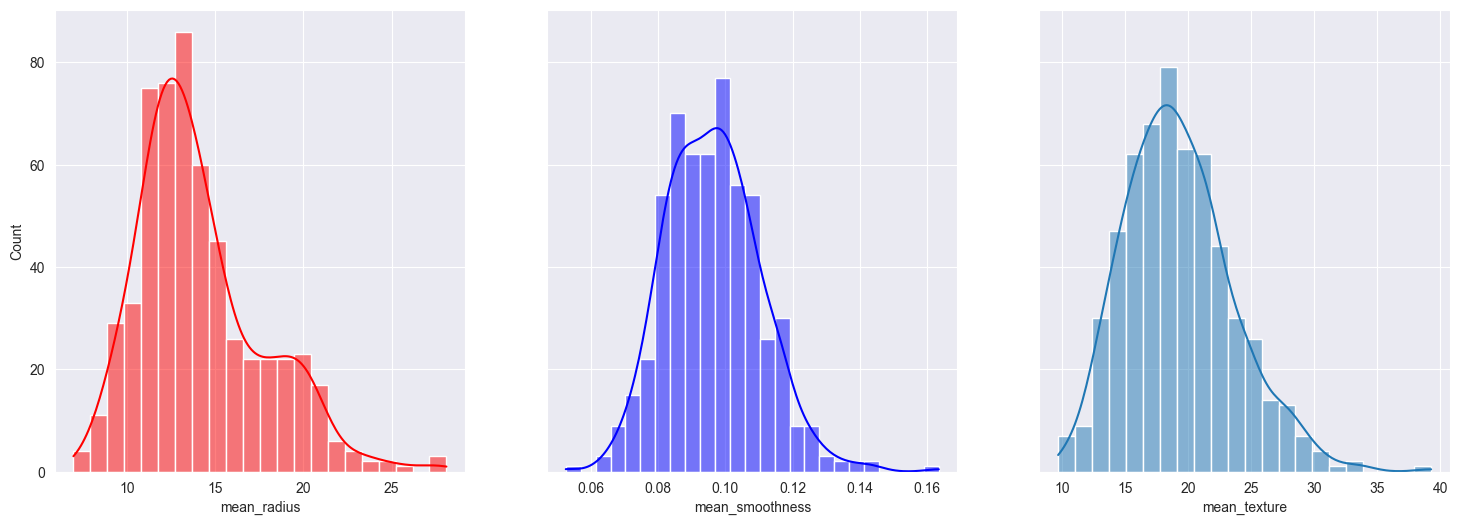

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.histplot(data, ax=axes[0], x="mean_radius", kde=True, color='r')
sns.histplot(data, ax=axes[1], x="mean_smoothness", kde=True, color='b')
sns.histplot(data, ax=axes[2], x="mean_texture", kde=True)

In [7]:
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df))
    return prior

In [8]:
def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))
    return p_x_given_y

In [9]:
def naive_bayes_gaussian(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

In [11]:

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# Encode the target variable in the original dataset
le = LabelEncoder()
data["diagnosis"] = le.fit_transform(data["diagnosis"])  # Converts 'B' -> 0, 'M' -> 1

# Split data
train, test = train_test_split(data, test_size=0.2, random_state=41)

# Prepare test data
X_test = test.iloc[:, :-1].values
Y_test = test.iloc[:, -1].values  # These are already encoded as integers

# Predictions (Gaussian or Categorical)
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="diagnosis")  # For Gaussian
# Y_pred = naive_bayes_categorical(train, X=X_test, Y="diagnosis")  # For Categorical

# Evaluate metrics
from sklearn.metrics import confusion_matrix, f1_score
print("Confusion Matrix:")
print(confusion_matrix(Y_test, Y_pred))
print("F1 Score:", f1_score(Y_test, Y_pred))

Confusion Matrix:
[[74  0]
 [ 4 36]]
F1 Score: 0.9473684210526315


In [12]:
data["cat_mean_radius"] = pd.cut(data["mean_radius"].values, bins = 3, labels = [0,1,2])
data["cat_mean_texture"] = pd.cut(data["mean_texture"].values, bins = 3, labels = [0,1,2])
data["cat_mean_smoothness"] = pd.cut(data["mean_smoothness"].values, bins = 3, labels = [0,1,2])

data = data.drop(columns=["mean_radius", "mean_texture", "mean_smoothness"])
data = data[["cat_mean_radius",	"cat_mean_texture",	"cat_mean_smoothness", "diagnosis"]]
data.head(10)

,cat_mean_radius,cat_mean_texture,cat_mean_smoothness,diagnosis
0,1,0,1,1
1,1,0,0,1
2,1,1,1,1
3,0,1,2,1
4,1,0,1,1
5,0,0,2,1
6,1,1,1,1
7,0,1,1,1
8,0,1,2,1
9,0,1,1,1


In [13]:
def calculate_likelihood_categorical(df, feat_name, feat_val, Y, label):
    df = df[df[Y] == label]
    if len(df) == 0:
        return 1e-6
    p_x_given_y = len(df[df[feat_name] == feat_val]) / len(df)
    return p_x_given_y



In [14]:
def naive_bayes_categorical(df, X, Y):
    features = list(df.columns)[:-1]
    prior = calculate_prior(df, Y)
    Y_pred = []

    for x in X:
        labels = sorted(df[Y].unique())
        likelihood = [1] * len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_categorical(df, features[i], x[i], Y, labels[j])
        post_prob = [likelihood[j] * prior[j] for j in range(len(labels))]
        Y_pred.append(np.argmax(post_prob))
    return np.array(Y_pred)

In [15]:
from sklearn.model_selection import train_test_split
train_test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_categorical(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[74  0]
 [40  0]]
0.0
